# Determination of ratio D in Forward Field Calculation using Tesseroid with Exponential Density

Our intention is to determine the ratio D needed to get an acceptable precission in the calculation of gravity fields using tesseroids with variable density that depends exponentialy on radius.

\begin{equation}
\rho(r') = Ae^{-r'/b}
\end{equation}

In order to do this, we are going to take into account an spherical shell with inner and outer radii $R_1$ and $R_2$, respectivetly. We will perform the fields calculation for different values of D and compare them with the analytical solutions obtained in the "02_spherical_shell_variable_density" notebook:

\begin{equation}
    V_\text{exp}^\text{dec}(r) = \frac{4\pi G Ab}{r} 
    \left[
    (R_1^2 + 2R_1 b + 2b^2)e^{-\frac{R_1}{b}} -
    (R_2^2 + 2R_2 b + 2b^2)e^{-\frac{R_2}{b}}
    \right]
\end{equation}

Due to the nature of the numerical approximation of the tesseroid field by point masses located in the nodes of the GLQ, the fields can vary between computation points at the same height but at different longitude, latitude locations. Because of this we will evaluate the fields in a small grid and the comparation will be made by calculating the maximum difference between the analytical solution and these computation points.


**Import Packages**

In [1]:
from __future__ import division
import numpy as np
from tesseroid_density import tesseroid
from fatiando.constants import G, MEAN_EARTH_RADIUS, SI2MGAL, SI2EOTVOS
from fatiando.mesher import Tesseroid, TesseroidMesh
from fatiando import gridder
import matplotlib.pyplot as plt

**Configuration for Pyplot Figures**

In [2]:
%matplotlib inline
plt.rcParams['axes.labelsize'] = 9.0 # fontsize of the x any y labels
plt.rcParams['xtick.labelsize'] = 9.0 # fontsize of the tick labels
plt.rcParams['ytick.labelsize'] = 9.0 # fontsize of the tick labels
plt.rcParams['legend.fontsize'] = 9.0
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Computer Modern Roman'
plt.rcParams['text.usetex'] = True # use latex for all text handling
plt.rcParams['text.color'] = '3a3a3a'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.edgecolor'] = '3a3a3a'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4
plt.rcParams['xtick.major.size'] = 2
plt.rcParams['ytick.major.size'] = 2

**Definition of exponential density function**

In [3]:
a = 1.
b = 1000*1e3

def density_exp(height):
    r = height + MEAN_EARTH_RADIUS
    return a*np.exp(-r/b)

**Definition of spherical shell potential function**

In [4]:
def shell_exp_density(height, top, bottom, a, b):
    r = height + MEAN_EARTH_RADIUS
    r1 = bottom + MEAN_EARTH_RADIUS
    r2 = top + MEAN_EARTH_RADIUS
    constant = 4*np.pi*G*a*b*((r1**2 + 2*r1*b + 2*b**2)*np.exp(-r1/b)-
                              (r2**2 + 2*r2*b + 2*b**2)*np.exp(-r2/b))
    potential = constant/r
    data = {'potential': potential,
            'gx': 0,
            'gy': 0,
            'gz': SI2MGAL*(potential/r),
            'gxx': SI2EOTVOS*(-potential/r**2),
            'gxy': 0,
            'gxz': 0,
            'gyy': SI2EOTVOS*(-potential/r**2),
            'gyz': 0,
            'gzz': SI2EOTVOS*(2*potential/r**2)}
    return data

**Definition of Spherical Shell and Tesseroid Model**

In [5]:
top, bottom = 0, -1000
model = TesseroidMesh((0, 360, -90, 90, top, bottom), (1, 6, 12))
model.addprop("density", [density_exp for i in range(model.size)])

**Determination of D for different grids**

In [6]:
shape = (10, 10)
grids = {"pole": gridder.regular((89, 90, 0, 1), shape, z=2e3),
         "equator": gridder.regular((0, 1, 0, 1), shape, z=2e3),
         "260km": gridder.regular((89, 90, 0, 1), shape, z=260e3),
         "30deg": gridder.regular((60, 90, 0, 30), shape, z=2e3)}
fields = 'potential gz gzz'.split()
D_values = np.arange(0.5, 10.5, 0.5)

for field in fields:
    for grid in grids.keys():
        lons, lats, heights = grids[grid]
        analytical = shell_exp_density(heights[0], top, bottom, a, b)
        diffs = []
        for D in D_values:
            result = getattr(tesseroid, field)(lons, lats, heights, model, ratio=D)
            diff = np.abs(result - analytical[field])/np.abs(analytical[field])
            diff = 100*np.max(diff)
            diffs.append(diff)
        diffs = np.array(diffs)
        np.savez('results/Dexp/' + field + '-' + grid + '-differences.npz',
                 D_values=D_values, diffs=diffs)

tesseroid_density/tesseroid.py:234: RuntimeWarning: Stopped dividing a tesseroid because it's dimensions would be below the minimum numerical threshold (1e-6 degrees or 1e-3 m). Will compute without division. Cannot guarantee the accuracy of the solution.
  warnings.warn(warning_msg, RuntimeWarning)


**Plot results**

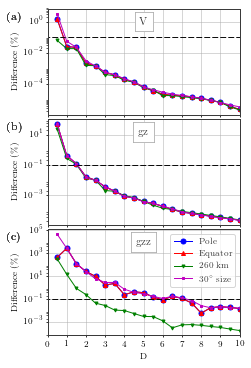

In [7]:
grids = ['pole', 'equator', '260km', '30deg']
fields = 'potential gz gzz'.split()
styles = ['-o', '-^', '-v', '-s']
msize = [5, 4, 3, 2]
colors = ['b', 'r', 'g', 'm']
labels = [r'Pole', r'Equator', r'260 km', r'$30^\circ$ size']
titles = 'V gz gzz'.split()
subfigure = '(a) (b) (c)'.split()

fig, axes = plt.subplots(nrows=len(fields), ncols=1, sharex=True)
fig.set_size_inches((3.33, 5))
fig.subplots_adjust(hspace=0)
for ax, field, title, sub in zip(axes, fields, titles, subfigure):
    for grid, style, c, label, ms in zip(grids, styles, colors, labels, msize):
        diffs = np.load('results/Dexp/' + field + '-' + grid + '-differences.npz')
        D_values, diff = diffs['D_values'], diffs['diffs']
        ax.plot(D_values, diff, style, markersize=ms,
                color=c, label=label)
        ax.text(-0.21, 0.9, sub, fontsize=12,
                fontdict={'weight': 'bold'},
                transform=ax.transAxes)
        ax.text(0.5, 0.88, title, fontsize=11,
                horizontalalignment='center',
                verticalalignment='center',
                bbox={'facecolor': 'w',
                      'edgecolor': '#9b9b9b',
                      'linewidth': 0.5, 'pad': 5},
                transform=ax.transAxes)
        ax.plot([-1, 11], [1e-1, 1e-1], '--',
                color='k', linewidth=0.5)
        ax.set_yscale('log')
        ax.set_yticks(ax.get_yticks()[2:-2])
        ax.set_ylabel('Difference (\%)')
        ax.grid(True, linewidth=0.5, color='#aeaeae')
        ax.set_axisbelow(True)
ax = axes[-1]
ax.set_xlabel(r"D")
ax.set_xlim(0, 10)
ax.set_xticks(np.arange(0, 11, 1))
ax.legend()
plt.tight_layout(pad=0.3, h_pad=0, w_pad=0)
plt.savefig('../figs/Dexp-differences.svg')
plt.show()

## Shifted exponential density

Now we are going to perform the same tests, but now with a shifted exponential density, thus:

\begin{equation}
\rho(r') = Ae^{-(r'-\Delta h)/b}
\end{equation}

The analytical solution of the potential generated by a spherical shell with this density function was obtained in the notebook called "02_spherical_shell_variable_density":

\begin{equation}
V_\text{exp}(r) = \frac{4\pi G Ab}{r} 
    e^\frac{\Delta h}{b}
    \left[
    (R_1^2 + 2R_1 b + 2b^2)e^{-\frac{R_1}{b}} -
    (R_2^2 + 2R_2 b + 2b^2)e^{-\frac{R_2}{b}}
    \right]
\end{equation}

**Definition of exponential density function**

In [8]:
a = 1.
b = 1e6
deltah = MEAN_EARTH_RADIUS

def density_exp_shifted(height):
    r = height + MEAN_EARTH_RADIUS
    return a*np.exp((deltah - r)/b)

**Definition of spherical shell potential function**

In [9]:
def shell_exp_density_shifted(height, top, bottom, a, b, deltah):
    r = height + MEAN_EARTH_RADIUS
    r1 = bottom + MEAN_EARTH_RADIUS
    r2 = top + MEAN_EARTH_RADIUS
    constant = 4*np.pi*G*a*b*np.exp(deltah/b)*((r1**2 + 2*r1*b + 2*b**2)*np.exp(-r1/b) -
                                               (r2**2 + 2*r2*b + 2*b**2)*np.exp(-r2/b))
    potential = constant/r
    data = {'potential': potential,
            'gx': 0,
            'gy': 0,
            'gz': SI2MGAL*(potential/r),
            'gxx': SI2EOTVOS*(-potential/r**2),
            'gxy': 0,
            'gxz': 0,
            'gyy': SI2EOTVOS*(-potential/r**2),
            'gyz': 0,
            'gzz': SI2EOTVOS*(2*potential/r**2)}
    return data

**Definition of Spherical Shell and Tesseroid Model**

In [10]:
top, bottom = 0, -1000
model = TesseroidMesh((0, 360, -90, 90, top, bottom), (1, 6, 12))
model.addprop("density", [density_exp_shifted for i in range(model.size)])

**Determination of D for different grids**

In [11]:
shape = (10, 10)
grids = {"pole": gridder.regular((89, 90, 0, 1), shape, z=2e3),
         "equator": gridder.regular((0, 1, 0, 1), shape, z=2e3),
         "260km": gridder.regular((89, 90, 0, 1), shape, z=260e3),
         "30deg": gridder.regular((60, 90, 0, 30), shape, z=2e3)}
fields = 'potential gz gzz'.split()
D_values = np.arange(0.5, 10.5, 0.5)

for field in fields:
    for grid in grids.keys():
        lons, lats, heights = grids[grid]
        analytical = shell_exp_density_shifted(heights[0], top, bottom, a, b, deltah)
        diffs = []
        for D in D_values:
            result = getattr(tesseroid, field)(lons, lats, heights, model, ratio=D)
            diff = np.abs(result - analytical[field])/np.abs(analytical[field])
            diff = 100*np.max(diff)
            diffs.append(diff)
        diffs = np.array(diffs)
        np.savez('results/Dexp-shifted/' + field + '-' + grid + '-differences.npz',
                 D_values=D_values, diffs=diffs)

**Plot results**

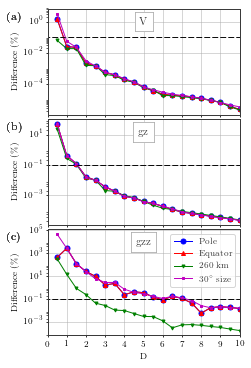

In [12]:
grids = ['pole', 'equator', '260km', '30deg']
fields = 'potential gz gzz'.split()
styles = ['-o', '-^', '-v', '-s']
msize = [5, 4, 3, 2]
colors = ['b', 'r', 'g', 'm']
labels = [r'Pole', r'Equator', r'260 km', r'$30^\circ$ size']
titles = 'V gz gzz'.split()
subfigure = '(a) (b) (c)'.split()

fig, axes = plt.subplots(nrows=len(fields), ncols=1, sharex=True)
fig.set_size_inches((3.33, 5))
fig.subplots_adjust(hspace=0)
for ax, field, title, sub in zip(axes, fields, titles, subfigure):
    for grid, style, c, label, ms in zip(grids, styles, colors, labels, msize):
        diffs = np.load('results/Dexp-shifted/' + field + '-' + grid + '-differences.npz')
        D_values, diff = diffs['D_values'], diffs['diffs']
        ax.plot(D_values, diff, style, markersize=ms,
                color=c, label=label)
        ax.text(-0.21, 0.9, sub, fontsize=12,
                fontdict={'weight': 'bold'},
                transform=ax.transAxes)
        ax.text(0.5, 0.88, title, fontsize=11,
                horizontalalignment='center',
                verticalalignment='center',
                bbox={'facecolor': 'w',
                      'edgecolor': '#9b9b9b',
                      'linewidth': 0.5, 'pad': 5},
                transform=ax.transAxes)
        ax.plot([-1, 11], [1e-1, 1e-1], '--',
                color='k', linewidth=0.5)
        ax.set_yscale('log')
        ax.set_yticks(ax.get_yticks()[2:-2])
        ax.set_ylabel('Difference (\%)')
        ax.grid(True, linewidth=0.5, color='#aeaeae')
        ax.set_axisbelow(True)
ax = axes[-1]
ax.set_xlabel(r"D")
ax.set_xlim(0, 10)
ax.set_xticks(np.arange(0, 11, 1))
ax.legend()
plt.tight_layout(pad=0.3, h_pad=0, w_pad=0)
plt.savefig('../figs/Dexp-shifted-differences.svg')
plt.show()

## Determination of D vs the constant b in the power

Now we are going to calculate the gzz component for different values of D and different values of the constant $b$ in the power of the density function in order to test how does the D behaves when the exponential density gets steeper.

**Definition of Spherical Shell and Tesseroid Model**

In [13]:
top, bottom = 0, -1000
model = TesseroidMesh((0, 360, -90, 90, top, bottom), (1, 6, 12))

**Definition of computation grid**

In [14]:
shape = (10, 10)
lons, lats, heights = gridder.regular((60, 90, 0, 30), shape, z=2e3)

**Determination of D for different constants b**

In [15]:
field = 'gzz'
a = 1.
b_values = [1e4, 1e5, 1e6]
deltah = MEAN_EARTH_RADIUS
D_values = np.arange(0.5, 10.5, 0.5)


for b in b_values:
    # Define new functions for each b
    def density_exp_shifted(height):
        r = height + MEAN_EARTH_RADIUS
        return a*np.exp((r - deltah)/b)

    def shell_exp_density_shifted(height, top, bottom, a, b, deltah):
        r = height + MEAN_EARTH_RADIUS
        r1 = bottom + MEAN_EARTH_RADIUS
        r2 = top + MEAN_EARTH_RADIUS
        constant = 4*np.pi*G*a*b*np.exp(-deltah/b)*((r2**2 - 2*r2*b + 2*b**2)*np.exp(r2/b) -
                                                    (r1**2 - 2*r1*b + 2*b**2)*np.exp(r1/b))
        potential = constant/r
        data = {'potential': potential,
                'gx': 0,
                'gy': 0,
                'gz': SI2MGAL*(potential/r),
                'gxx': SI2EOTVOS*(-potential/r**2),
                'gxy': 0,
                'gxz': 0,
                'gyy': SI2EOTVOS*(-potential/r**2),
                'gyz': 0,
                'gzz': SI2EOTVOS*(2*potential/r**2)}
        return data

    analytical = shell_exp_density_shifted(heights[0], top, bottom, a, b, deltah)
    diffs = []
    model.addprop("density", [density_exp_shifted for i in range(model.size)])
    for D in D_values:
        result = getattr(tesseroid, field)(lons, lats, heights, model, ratio=D)
        diff = np.abs(result - analytical[field])/np.abs(analytical[field])
        diff = 100*np.max(diff)
        diffs.append(diff)
    diffs = np.array(diffs)
    np.savez('results/Dexp-vs-power/' + field + '-' + '{:.0e}'.format(b) + '-differences.npz',
             D_values=D_values, diffs=diffs)

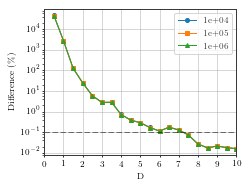

In [16]:
b_values = [1e4, 1e5, 1e6]
markers = ["o", "s", "^", "v", "D"]
field = 'gzz'

fig, ax = plt.subplots()
fig.set_size_inches((3.33, 2.5))
for b, m in zip(b_values, markers):
    diffs = np.load('results/Dexp-vs-power/' + field + '-' +
                    '{:.0e}'.format(b) + '-differences.npz')
    D_values, diff = diffs['D_values'], diffs['diffs']
    ax.plot(D_values, diff, '-', marker=m,
            label='{:.0e}'.format(b))

ax.plot([0, 10], [1e-1, 1e-1], '--', color='k', linewidth=0.5)
ax.set_yscale('log')
ax.set_yticks(ax.get_yticks()[2:-2])
ax.set_ylabel('Difference (\%)')
ax.grid(True, linewidth=0.5, color='#aeaeae')
ax.set_axisbelow(True)
ax.set_xlabel(r"D")
ax.set_xlim(0, 10)
ax.set_xticks(np.arange(0, 11, 1))
plt.legend()
plt.tight_layout(pad=0.3, h_pad=0, w_pad=0)
plt.savefig('../figs/Dexp-vs-power-differences.svg')
plt.show()